# Debugging:
## This script imports C and Python HDF output for comparison

In [304]:
import h5py
import numpy as np
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')
%matplotlib inline
import subprocess

# Labels and timestamps

In [305]:
# and its filename
#
py_filename = "output_acoustic_wave_high_low_mach_gravity_comp.h5"
py_filename = "output_internal_long_wave_low_mach_gravity_comp.h5"
py_filename = "output_travelling_vortex_3d_48_low_mach_gravity_comp.h5"

#####################################################

figsize_tuple = (12,3)

## Converter

Converts all hdf4 output of RKLM C-code to hdf5.

In [323]:
def convert_c(time,base_suffix,typ,tag,debug=False):
    base_folder_name = "output"

    base_path = base_folder_name + base_suffix
    folder_comp = "low_Mach_gravity_comp/"
    folder_psinc = "low_Mach_gravity_psinc/"
    
    if typ == 'PI':
        folder_type = folder_psinc
    if typ == 'COMP':
        folder_type = folder_comp

    # Manually list the folder names for each output
    directories = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_nodes', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
    directories += ['rhou', 'rhov', 'rhow', 'rhs']
    directories += ['buoy']

    # And manually list the file names.
    filenames = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_n', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_n', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
    filenames += ['rhou', 'rhov', 'rhow', 'rhs']
    filenames += ['buoy']

    # specify the format extensions for input and output of converter
    hdf_format = '.'+ 'hdf'
    h5_format = '.' + 'h5'

    if tag == 'before_advect' or tag == 'after_half_step':
        directories += ['rhoYu', 'rhoYv']
        filenames += ['rhoYu', 'rhoYv']

    # if time == t_label + '_' + 'after_ebnaimp':
    #     directories += ['wplusx', 'wplusy', 'hcenter', 'pnew', 'rhs_nodes', 'p2_initial']
    #     filenames += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']

    string_hdf = '_' + time + hdf_format
    string_h5 = '_' + time + h5_format
    full_path = base_path + folder_type

    lst_hdf = []
    lst_h5 = []

    # build list of paths from parameters specified above.
    i = 0
    for directory in directories:
        lst_hdf.append(full_path + directory + '/' + filenames[i] + string_hdf)
        lst_h5.append(full_path + directory + '/' + filenames[i] + string_h5)
        i += 1 

    # print the list of paths
    if debug == True:
        for path in lst_hdf:
            print(path)

    # now, convert the arrays specified in the list of paths
    for item in lst_hdf:
        p = subprocess.call(["./h4toh5convert", item])
        
    return string_h5, full_path

## Import C hdf5 output

Import the test case arrays from the c-output.

In [325]:
def import_c(string_h5, full_path, tag):
    # manually specific folder names
    test_cases_folders = ['p2_c', 'dp2_nodes', 'p', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']

    # and filenames
    test_cases_names = ['p2_c', 'dp2_n', 'p', 'p2_n', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']

    if tag == 'before_advect' or tag == 'after_half_step':
        test_cases_folders += ['rhoYu','rhoYv']
        test_cases_names += ['rhoYu', 'rhoYv']

    # if time == t_label + '_' + 'after_ebnaimp':
    #     test_cases_folders += ['wplusx', 'wplusy', 'hcenter', 'pnew', 'rhs_nodes', 'p2_initial']
    #     test_cases_names += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']

    test_cases_folders = np.char.array(test_cases_folders)
    test_cases_names = np.char.array(test_cases_names)

    # build paths from folder names and filenames
    test_cases_paths = full_path + test_cases_folders + '/' + test_cases_names + string_h5

    # define empty class as a holder for all the C-hdf5 output.
    class c_output(object):
        def __init__(self):
            None

        def c_out(self):
            for key,value in vars(self).items():
                setattr(self,key,value['Data-Set-2'])

    # get an instance of an empty class to populate it with the C-HDF output as attributes
    c = c_output()

    # populate the class with the C-HDF output as attributes
    i = 0
    for path in test_cases_paths:
        setattr(c,test_cases_folders[i],h5py.File(path, 'r'))
        i += 1


    # run the method to extract array from HDF objects
    c.c_out()
    return c

## Import the Python output

In [326]:
# specify directory where the python hdf5 output is.
# py_directory = "../RKLM_Python/"
py_directory = "../"

py_path = py_directory + py_filename

# helper function to extract array from hdf file by its name and timestep

label = '_' + label
def py_out(py_dataset,time=label):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def get_filename(grid_x,grid_y,size,end_time,suffix):
    fn = "output_travelling_vortex_ensemble=%i_%i_%i_%.1f_%s.h5" %(size,grid_x,grid_y,end_time,suffix)
    return fn
#     return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

inner = (slice(2,-2),slice(2,-2))
#     inner = (slice(None,),slice(None,))

def ensemble_test_case(time, path, N, attribute, tag):

    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        
        if type(time) == 'float':
            t_label = '_ensemble_mem=%i_%.3d_after_full_step' %(n,time)
        else:
#             t_label = '_ensemble_mem=%i_%s_after_full_step' %(n,time)
            t_label = '_%.3d_%s' %(time,tag)
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return array

def diff_plot(py_arr,c_arr,time,att):
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    im0 = ax[0].imshow(c_arr[inner])
    ax[0].set_title("(48x48), C-output")
    im1 = ax[1].imshow(py_arr)
    fig.colorbar(im0,ax=ax[0],shrink=.75)
    ax[1].set_title("(48x48), Py-output")
    fig.colorbar(im1,ax=ax[1],shrink=.75)
    im2 = ax[2].imshow(np.abs(c_arr[inner] - py_arr))
    ax[2].set_title("abs. diff. between outputs")
    fig.colorbar(im2,ax=ax[2],shrink=.75)
    fig.suptitle(r'Comparing measurements at time step=%.3d for quantity %s' %(time,att), fontsize='16')
    plt.show()

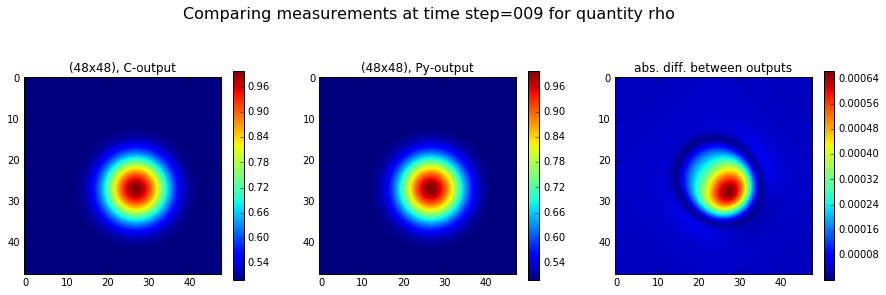

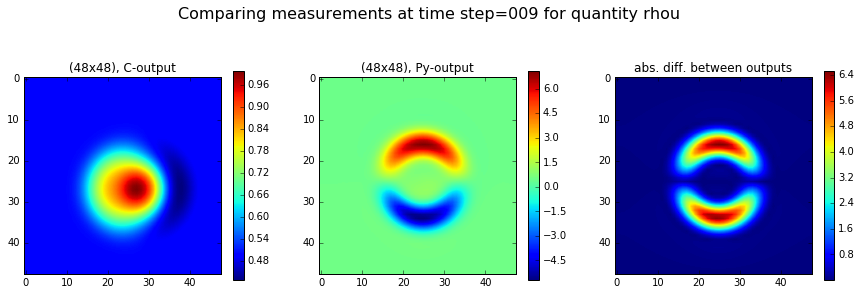

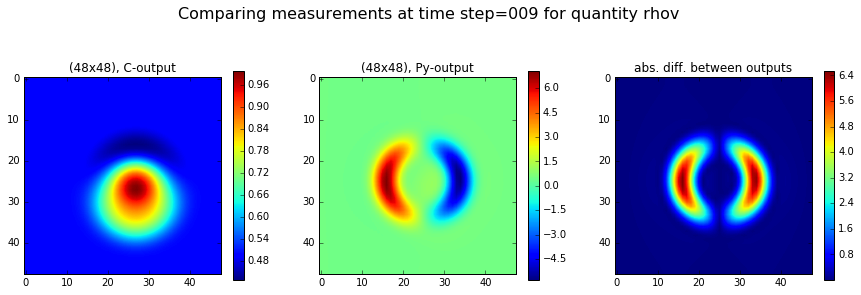

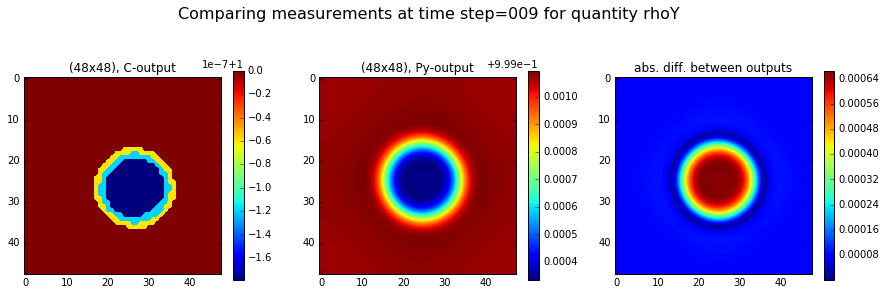

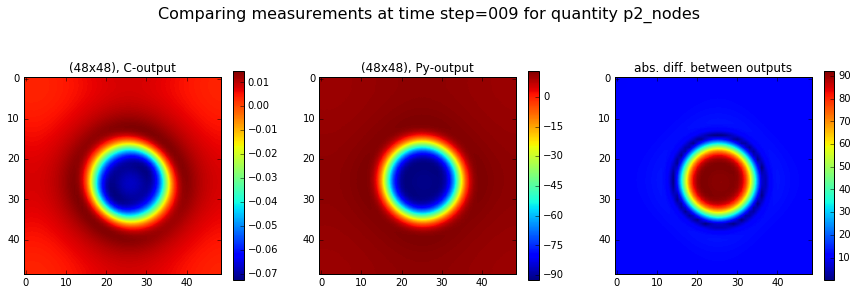

In [360]:
py_time = 9

typ = 'COMP'
# typ = 'PI'

tag = 'ic'
# tag = 'before_advect'
# tag = 'after_advect'
# tag = 'after_ebnaexp'
tag = 'after_ebnaimp'
tag = 'after_half_step'
tag = 'after_efna'
# tag = 'after_full_advect'
# tag = 'after_full_ebnaexp'
# tag = 'after_full_step'

#####################################################
#
# Time labels for C and Python
#
t_label = '%.3d' %py_time
time = t_label + '_' + tag
#####################################################

#####################################################
#
# C-output folder names
#
# base_suffix = '_acoustic_wave_high/'
# base_suffix = '_internal_long_wave/'
# base_suffix = '_travelling_vortex_3d_48_no_initial_projection/'
base_suffix = '_travelling_vortex_3d_48_with_initial_projection/'
# 
#####################################################

py_directory = "../"
py_directory += "output_travelling_vortex/"

string_h5, full_path = convert_c(time,base_suffix,typ,tag)
c = import_c(string_h5, full_path,tag)

grid_x = 48
grid_y = 48
ref_size = 1
end_time = 1.0

if typ == 'COMP': suffix = 'comp'
if typ == 'PI': suffix = 'psinc'

py_filename_ref = get_filename(grid_x, grid_y, ref_size, end_time, suffix)
py_path = get_path(py_filename_ref)

atts = ['rho',
          'rhou',
          'rhov',
          'rhoY',
          'p2_nodes',
         ]

if tag == 'before_advect' or tag == 'after_half_step':
    atts += ['rhoYu', 'rhoYv']

# py_arr = ensemble_test_case(py_time,py_path,1,'p2_nodes',tag)
# c_arr = c.p2_nodes

for att in atts:
    py_arr = ensemble_test_case(py_time,py_path,1,att,tag)
    c_arr = getattr(c,att)
    diff_plot(py_arr,c_arr,py_time,att)

# print((np.abs(c.rho[inner] - py_rho) / c.rho[inner]).max())

In [318]:
py_directory = "../"
py_directory += "output_travelling_vortex/"

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

inner = (slice(2,-2),slice(2,-2))
#     inner = (slice(None,),slice(None,))

def ensemble_test_case(time, path, N, attribute, tag):

    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        
        if type(time) == 'float':
            t_label = '_ensemble_mem=%i_%.2f_after_full_step' %(n,time)
        else:
#             t_label = '_ensemble_mem=%i_%s_after_full_step' %(n,time)
            t_label = '_%s_%s' %(time,tag)
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return array


grid_x = 48
grid_y = 48
ref_size = 1
end_time = 1.0
py_time = 1.0
py_time = '000'

tag = 'ic'
# tag = 'before_advect'
# tag = 'after_advect'
# tag = 'after_ebnaexp'
# tag = 'after_ebnaimp'
# tag = 'after_half_step'
# tag = 'after_efna'
# tag = 'after_full_advect'
# tag = 'after_full_ebnaexp'
# tag = 'after_full_step'

py_filename_ref = get_filename(grid_x, grid_y, ref_size, end_time, "")
py_path = get_path(py_filename_ref)

py_rho0 = ensemble_test_case(py_time,py_path,1,'rhs',tag)

py_filename_ref = get_filename(grid_x, grid_y, ref_size, end_time, "_working")
py_path = get_path(py_filename_ref)

py_rho = ensemble_test_case(py_time,py_path,1,'rhs',tag)

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
im0 = ax[0].imshow(py_rho0)
ax[0].set_title("(48x48), C-output")
im1 = ax[1].imshow(py_rho)
fig.colorbar(im0,ax=ax[0],shrink=.75)
ax[1].set_title("(48x48), Py-output")
fig.colorbar(im1,ax=ax[1],shrink=.75)
im2 = ax[2].imshow(np.abs(py_rho0 - py_rho))
ax[2].set_title("abs. diff. between outputs")
fig.colorbar(im2,ax=ax[2],shrink=.75)
fig.suptitle(r'Comparing measurements at time=0.0 for quantity p2_nodes', fontsize='16')
plt.show()

KeyError: "Unable to open object (object 'rhs' doesn't exist)"

## Helper diagnostic functions

# print an array
def p(obj):
    print(obj)
    
# visualise an array
def v(obj):
    plt.imshow(obj)
    plt.colorbar()
    plt.show()
    
# plot a slice of the array, default is x = 0 for all y (slice at origin)
def s(obj,slc=(slice(None))):
    plt.plot(obj['Data-Set-2'][slc])
    plt.show()
    
# plot the difference between the C and Python outputs
def diff(obj_c, obj_py, title, option = None):
#     obj_c = obj_c[2:-2,2:-2]
#     obj_c -= obj_c.mean()
#     obj_py = obj_py[2:-2,2:-2]
#     obj_py -= obj_py.mean()
#     
    c_range = np.max(obj_c) - np.min(obj_c)
    py_range = np.max(obj_py) - np.min(obj_py)
    if option == None:
        max_norm = np.abs(obj_c - obj_py)
    else:
        max_norm = (obj_c - obj_py)
    
    max_diff = np.max(max_norm)
    
    fig, ax = plt.subplots(ncols=3, figsize=figsize_tuple)
    # plot c array
    im_c = ax[0].pcolor(obj_c, label="c")
    fig.colorbar(im_c,ax=ax[0])
    ax[0].set_title("c")
    ax[0].set_aspect('auto')
    
    # plot python array
    im_py = ax[1].pcolor(obj_py, label="py")
    fig.colorbar(im_py,ax=ax[1])
    ax[1].set_title("py")
    ax[1].set_aspect('auto')

    # plot the difference between the two
    im_diff = ax[2].pcolor(max_norm, label="diff")
    fig.colorbar(im_diff,ax=ax[2])
    ax[2].set_title("diff")
    ax[2].set_aspect('auto')
    
    # calculate the max difference relative to the C-output for non-zero values.
    if c_range == 0.0:
        rel_diff = 0.0
    else:
        rel_diff = max_diff/c_range
        
    print("comparison = %s,\nc_range = %e, py_range = %e, \nmax diff = %e, rel. diff = %e," %(title, c_range, py_range, max_diff, rel_diff))
    plt.tight_layout(h_pad=1)
    plt.show()
    print("################################################## \n")

In [ ]:
# # open the Python HDF file
# pyfile = h5py.File(py_path, 'r')

# py_time = 0.0

# # make comparisons for the arrays.
# # Arguments: C-array (class attribute), Python-array (numpy array), and a title.
# # PPP = np.copy(py_out('dp2_nodes'))
# # PPP[:,-4:-2] = py_out('dp2_nodes')[:,2:4][::-1]

# # diff(c.pnew, PPP, 'dp2_nodes')

# inner = (slice(2,-2),slice(2,-2))
# iwp = (slice(2,-2),slice(2,-2))
# iwp_e = (slice(2,-2),slice(2,-2))
# iwp_n = (slice(2,-3),slice(2,-3))
# # iwp = (slice(None),slice(None))
# if time == t_label + '_' + 'after_ebnaimp':
# #     diff(c.hcenter, py_out('hcenter'), 'hcenter')
# #     diff(c.wplusx[iwp], py_out('wplusx')[iwp_n], 'wplusx')
# #     diff(c.wplusy[iwp], py_out('wplusy')[iwp_n], 'wplusy')
#     diff(c.pnew[inner], py_out('p2_full')[inner], 'p2_full', option='na')
# #     diff(c.rhs_nodes, py_out('rhs_nodes'), 'rhs_nodes')
# #     diff(c.p2_initial, py_out('p2_initial'), 'p2_initial')
    
# if time == '001' or time == '005':
#     diff(c.flux_x, py_out('rhoYu').T, 'rhoYu')
#     diff(c.flux_y, py_out('rhoYv').T, 'rhoYv')
    
# # print(py_out('lap_test'))
# # fig = plt.figure(figsize=(5,5))
# # plt.pcolor(py_out('lap_test'))
# # plt.colorbar()
# # plt.show()

# # diff(c.pnew,py_out('dp2_nodes'),'dp2_nodes')
# # diff(c.rhs, py_out('rhs'), 'rhs')
# diff(c.p2_nodes,py_out('p2_nodes'),'p2_nodes', option='na')
# # diff(c.buoy,py_out('X'),'buoy')
# # diff(c.dp2_c,py_out('dp2_cells'),'dp2_cells')
# # diff(c.p2_c,py_out('p2_cells'),'p2_cells')

# # diff(c.rho,py_out('rho'),'rho')
# # # diff(c.rhoe,py_out('rhoe'),'rhoe')
# # diff(c.rhoY,py_out('rhoY'),'rhoY')

# # diff(c.rhou,py_out('rhou'),'rhou', option='na')
# # # print(np.argmax(np.abs(c.rhou - py_out('rhou'))))
# # diff(c.rhov,py_out('rhov'),'rhov')
# # diff(c.rhow,py_out('rhow'),'rhow')

# # diff(c.u, py_out('u'), 'u')
# # diff(c.p, py_out('p'), 'p')
# # diff(c.dpdim, py_out('dpdim'), 'dpdim')
# # diff(c.vortz, py_out('vortz'), 'vortz')

# # diff(c.T, py_out('T'), 'T')
# # diff(c.dT, py_out('dT'), 'dT')

# # diff(c.Y, py_out('Y'), 'Y')
# # diff(c.dY, py_out('dY'), 'dY')

# # print(c.hcenter[:][2:-2,2:-2])
# # print(py_out('hcenter')[2:-2,2:-2])

# # print(np.where(py_out('p2_initial')[inner] == 0.)[0])

# # if time == '004':
# #     idx = 0
# #     fig = plt.figure(figsize=(9,9))
# #     plt.plot(py_out('p2_full')[inner][:,idx], 'r')
# #     plt.plot(c.pnew[inner][:,7])
# #     plt.xlabel('p2_full')
# #     plt.ylabel('error')
# #     plt.show()

# #     fig = plt.figure(figsize=(9,9))
# #     plt.plot((py_out('p2_full') - c.pnew)[inner][:,idx])
# #     plt.xlabel('diff')
# #     plt.ylabel('error')
# #     plt.show()
    
# #     fig = plt.figure(figsize=(9,9))
# #     plt.plot((py_out('p2_initial')[inner])[:,7])
# #     plt.xlabel('p2_initial')
# #     plt.ylabel('value')
# #     plt.show()
    
# #     print(py_out('p2_initial')[inner][2,:][:10])
    
# if time == '002':
#     idx = 1
#     fig = plt.figure(figsize=(9,9))
#     plt.plot(py_out('rhou')[:,idx],'r', label='python-output')
#     plt.plot(c.rhou[:,idx],'k', label='c-output')
#     plt.title('rhou, sliced at idx %i' %idx )
#     plt.ylabel('rhou')
#     plt.xlabel('x')
#     plt.legend()
#     plt.show()
    
#     fig = plt.figure(figsize=(9,9))
#     plt.plot((py_out('rhou') - c.rhou)[:,idx])
#     plt.title('difference in rhou outputs, sliced at idx %i' %idx )
#     plt.xlabel('diff')
#     plt.ylabel('error')
#     plt.show()
    
    
# if time == '007':
#     idx = 10
#     fig = plt.figure(figsize=(9,9))
# #     plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx])
# #     plt.plot(py_out('rhou')[:,idx][:2],'r', label='python-output')
# #     plt.plot(c.rhou[:,idx][:2],'k', label='c-output')
#     plt.plot((py_out('rhou') - c.rhou)[:,idx][:5])
#     plt.title('difference in rhou outputs, sliced at idx %i' %idx )
#     plt.xlabel('diff')
#     plt.ylabel('error')
#     plt.show()
    
# if time == '005':
#     idx = 3
#     fig = plt.figure(figsize=(9,9))
#     plt.plot((py_out('rhoYu').T - c.flux_x)[:,idx])
#     plt.title('difference in rhoYu outputs, sliced at idx %i' %idx )
#     plt.xlabel('diff')
#     plt.ylabel('error')
#     plt.show()
    
# if time == '003':
#     idx = 100
#     fig = plt.figure(figsize=(9,9))
#     plt.plot(py_out('rhov')[idx,:], '-ro',label='python')
#     plt.plot(c.rhov[idx,:], '-bo',label='c')
#     plt.title("rhov sliced at the 100th row (i.e. at x = 100)")
#     plt.xlabel("y")
#     plt.ylabel("rhov")
#     plt.legend()
#     plt.show()
    
# # if time == t_label + '_' + 'after_half_step':
# # idx = 7
# # fig = plt.figure(figsize=(15,9))
# # # plt.plot(py_out('rhou')[:,idx],'r', label='python-output')
# # # plt.plot(c.rhou[:,idx],'k', label='c-output')
# # plt.plot((py_out('rhou') - c.rhou)[:,idx], label='diff profile')
# # plt.title('difference in rhou outputs, sliced at idx %i' %idx )
# # plt.xlabel('diff')
# # plt.ylabel('error')
# # plt.legend()
# # plt.show()

# # idx = 12
# # fig = plt.figure(figsize=(15,9))
# # # plt.plot(py_out('p2_nodes')[:,idx],'r', label='python-output')
# # # plt.plot(c.p2_nodes[:,idx],'k', label='c-output')
# # plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx], label='diff profile')
# # plt.title('difference in p2_nodes outputs, sliced at idx %i' %idx )
# # plt.xlabel('diff')
# # plt.ylabel('error')
# # plt.legend()
# # plt.show()

# # idx = 100
# # fig = plt.figure(figsize=(15,9))
# # plt.plot(py_out('p2_full')[inner][idx,:],'r', label='python-output')
# # plt.plot(c.pnew[inner][idx,:],'k', label='c-output')
# # # plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx], label='diff profile')
# # plt.title('difference in p2_nodes outputs, sliced at idx %i' %idx )
# # plt.xlabel('diff')
# # plt.ylabel('error')
# # plt.legend()
# # plt.show()

# pyfile.close()

In [ ]:
# pyfile.close()

In [ ]:
# plt.figure()
# plt.imshow(c.rho)
# plt.show()